In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import anndata
import umap.umap_ as umap
import leidenalg
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors

%matplotlib inline

### revisions checklist

- [x] use median instead of mean
- [ ] count cells for each section
- [ ] generate histogram for each section as baseline (ideally use 3m control for all tech)
- [x] filter out 0 gene cells
- [x] for each gene in overlap, generate histogram
- [ ] compare other 3 technologies to Gellyfish
- [ ] show specificity of each technique
- [ ] vizgen data should have much larger center count
- [ ] generate violin plot for all genes with median
- [ ] generate violin plot for overlap genes with median
- [ ] generate violin plot for individual overlap genes with median
    - [ ] vizgen should be better than xenium
    - [ ] verify if counts and center make sense

# Xenium Analysis

In [2]:
sample_id_list = ['C3m1', 'C3m2', 'C3m3', 'C24m1', 'C24m2', 'C24m3', 'HD24m1', 'HD24m2', 'HD24m3', 'R61']

In [3]:
concated_cell_csv = pd.DataFrame()
for sample_id in sample_id_list:
    df = pd.read_csv(rf"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\xenium_prerelease_molina_mouse_brain_Mar13\{sample_id}\cells.csv.gz")
    df['sample_id'] = sample_id
    concated_cell_csv = pd.concat([concated_cell_csv, df])

### filter out 0 gene cells

In [4]:
concated_cell_csv_filtered = concated_cell_csv[concated_cell_csv['transcript_counts'] > 0]
concated_cell_csv_filtered

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,total_counts,cell_area,nucleus_area,sample_id
0,1,1470.409833,4249.051636,4,0,0,0,4,178.186563,44.704687,C3m1
1,2,1474.557941,4239.123071,12,0,0,0,12,50.439531,29.487031,C3m1
2,3,1474.138440,4230.722266,34,0,0,0,34,251.430000,54.639063,C3m1
3,4,1479.313043,4242.560010,3,0,0,0,3,50.665312,23.345781,C3m1
4,5,1486.422662,4240.159839,6,0,0,0,6,59.199844,29.712812,C3m1
...,...,...,...,...,...,...,...,...,...,...,...
62701,62702,4511.553882,772.796457,1,0,0,0,1,831.913594,6.637969,R61
62704,62705,4500.247803,810.598993,1,0,0,0,1,616.021563,26.642187,R61
62710,62711,4537.563965,827.317804,4,0,0,0,4,886.326875,41.814688,R61
62712,62713,4795.765991,725.019598,2,0,0,0,2,987.702656,24.023125,R61


In [5]:
xenium_filtered_transcripts = concated_cell_csv_filtered['transcript_counts']
xenium_filtered_transcripts

0         4
1        12
2        34
3         3
4         6
         ..
62701     1
62704     1
62710     4
62712     2
62714     2
Name: transcript_counts, Length: 553305, dtype: int64

In [6]:
print(f'Xenium median transcript count: {xenium_filtered_transcripts.median()}')
print(f'Xenium min transcript count: {xenium_filtered_transcripts.min()}')
print(f'Xenium max transcript count: {xenium_filtered_transcripts.max()}')

Xenium median transcript count: 178.0
Xenium min transcript count: 1
Xenium max transcript count: 1526


Text(0.5, 1.0, 'Xenium - Number of transcripts per cell')

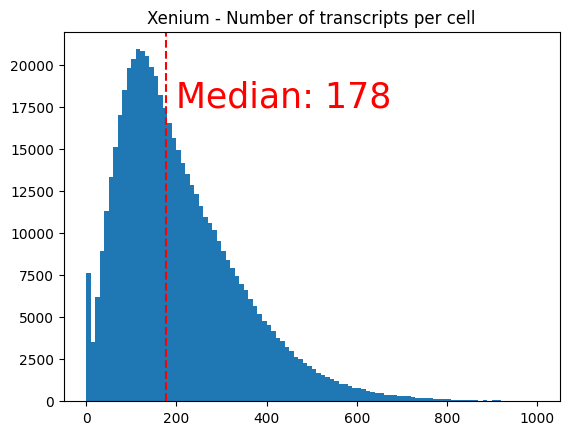

In [7]:
# how can I filter out extreme outliers?
# will this still be necessary if I am finding median

plt.hist(xenium_filtered_transcripts, bins = 100, range = (0, 1000))
plt.axvline(xenium_filtered_transcripts.median(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(200, 17500, f'Median: {int(xenium_filtered_transcripts.median())}', color = 'red', fontsize = 25)
#plt.axvline(xenium_transcripts.mean() - xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(380, 25000, f'SD: {int(xenium_transcripts.std())}', color = 'green', fontsize = 15)
#plt.axvline(xenium_transcripts.mean() + xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Xenium - Number of transcripts per cell')

In [8]:
xenium_violin_plot_df = pd.DataFrame()

In [9]:
xenium_violin_plot_df['transcript_count'] = xenium_filtered_transcripts
xenium_violin_plot_df['technology'] = 'Xenium'

In [10]:
xenium_violin_plot_df

,transcript_count,technology
0,4,Xenium
1,12,Xenium
2,34,Xenium
3,3,Xenium
4,6,Xenium
...,...,...
62701,1,Xenium
62704,1,Xenium
62710,4,Xenium
62712,2,Xenium


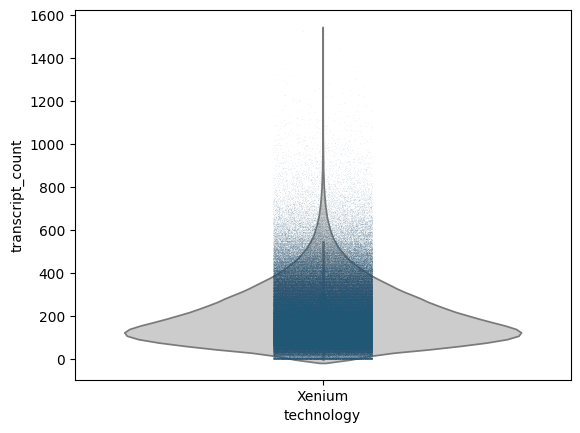

In [11]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = xenium_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = xenium_violin_plot_df, jitter = True, size = 0.15)
plt.show()

In [12]:
# count the number of cells in each section
# should I make a histogram for each section
concated_cell_csv_filtered['sample_id'].value_counts()

HD24m2    65125
R61       62362
HD24m1    57250
C3m2      56154
C24m2     54253
C24m1     53583
C24m3     53459
C3m1      52483
HD24m3    49758
C3m3      48878
Name: sample_id, dtype: int64

# Cosmx Analysis

In [13]:
cosmx_gene_exp = pd.read_csv(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\5 Raw data\MsBrain_exprMat_file.csv")
cosmx_gene_exp = cosmx_gene_exp.drop(columns = ['fov', 'cell_ID'])
cosmx_gene_exp

,Chrna4,Slc6a1,Cd109,Ldha,Aldoc,Drd1,Tank,Rit2,Prkag2,Lpar3,...,NegPrb1,NegPrb2,NegPrb3,NegPrb4,NegPrb5,NegPrb6,NegPrb7,NegPrb8,NegPrb9,NegPrb10
0,6,19,11,27,106,17,15,14,6,8,...,3,1,6,6,7,14,1,8,5,6
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134768,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134770,0,1,0,0,3,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
134771,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
cosmx_gene_exp_revised = cosmx_gene_exp.iloc[:, :-10]
cosmx_transcript_counts = cosmx_gene_exp_revised.sum(axis = 1)
cosmx_transcript_counts_filtered = cosmx_transcript_counts[cosmx_transcript_counts != 0]
cosmx_transcript_counts_filtered

0         17818
2            14
3            26
4            12
5           171
          ...  
134768       60
134769       42
134770      308
134771      108
134772      200
Length: 134635, dtype: int64

In [15]:
print(f'Cosmx median transcript count: {cosmx_transcript_counts_filtered.median()}')
print(f'Cosmx min transcript count: {cosmx_transcript_counts_filtered.min()}')
print(f'Cosmx max transcript count: {cosmx_transcript_counts_filtered.max()}')

Cosmx median transcript count: 310.0
Cosmx min transcript count: 1
Cosmx max transcript count: 129447


Text(0.5, 1.0, 'Cosmx - Number of transcripts per cell')

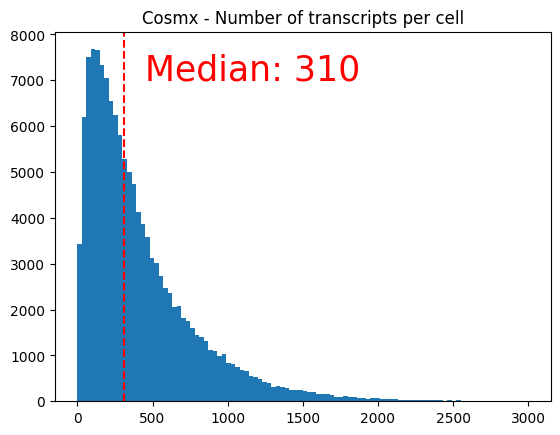

In [16]:
# how can I filter out extreme outliers?
# will this still be necessary if I am finding median

plt.hist(cosmx_transcript_counts_filtered, bins = 100, range = (0, 3000))
plt.axvline(cosmx_transcript_counts_filtered.median(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(450, 7000, f'Median: {int(cosmx_transcript_counts_filtered.median())}', color = 'red', fontsize = 25)
#plt.axvline(xenium_transcripts.mean() - xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(380, 25000, f'SD: {int(xenium_transcripts.std())}', color = 'green', fontsize = 15)
#plt.axvline(xenium_transcripts.mean() + xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Cosmx - Number of transcripts per cell')

In [17]:
cosmx_violin_plot_df = pd.DataFrame()

In [18]:
cosmx_violin_plot_df['transcript_count'] = cosmx_transcript_counts_filtered
cosmx_violin_plot_df['technology'] = 'Cosmx'
cosmx_violin_plot_df

,transcript_count,technology
0,17818,Cosmx
2,14,Cosmx
3,26,Cosmx
4,12,Cosmx
5,171,Cosmx
...,...,...
134768,60,Cosmx
134769,42,Cosmx
134770,308,Cosmx
134771,108,Cosmx


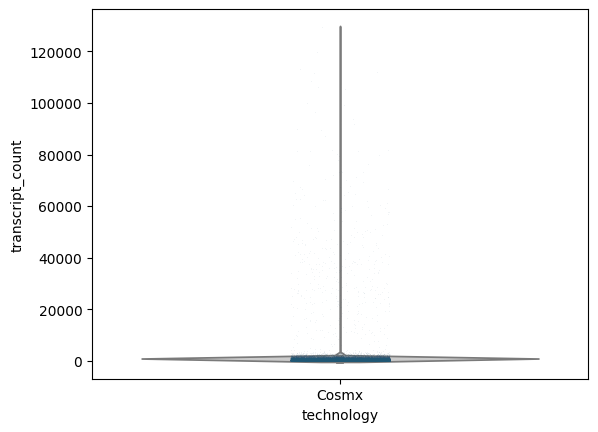

In [19]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = cosmx_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = cosmx_violin_plot_df, jitter = True, size = 0.15)
plt.show()

# Vizgen Analysis

In [20]:
region_list = ['Region 0', 'Region 1', 'Region 2', 'Region 3']

In [21]:
df_transcripts = pd.read_csv(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Vizgen Analysis\Region 3 Revised\detected_transcripts.csv")
df_transcripts

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id
0,4,55,6208.2520,3428.4253,0.0,1923.81290,260.67804,1351,Cxcl14,ENSMUST00000021970,-1
1,13,213,6208.6074,3428.0742,0.0,1927.10660,257.42890,1351,Olig1,ENSMUST00000056882,-1
2,8,258,6208.8580,3425.5227,0.0,1929.42460,233.80403,1351,Gfap,ENSMUST00000067444,-1
3,97,389,6204.1680,3509.3745,0.0,1886.00120,1010.20870,1351,Pde11a,ENSMUST00000124825,-1
4,138,389,6163.7124,3546.2880,0.0,1511.41100,1352.00000,1351,Pde11a,ENSMUST00000124825,-1
...,...,...,...,...,...,...,...,...,...,...,...
32949970,165,325,11272.5000,2579.9592,6.0,663.00000,1664.51200,1843,4930452B06Rik,ENSMUST00000102996,-1
32949971,71,369,11270.8160,2579.0234,6.0,647.41020,1655.84830,1843,Nrp2,ENSMUST00000114155,-1
32949972,73,369,11271.4780,2579.1912,6.0,653.52800,1657.40140,1843,Nrp2,ENSMUST00000114155,-1
32949973,111,389,11319.1650,2498.0870,6.0,1095.07930,906.43480,1843,Pde11a,ENSMUST00000124825,-1


In [22]:
df_cell = pd.read_csv(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Vizgen Analysis\Region 3 Revised\cell_metadata.csv")
df_cell

,EntityID,fov,volume,center_x,center_y,min_x,min_y,max_x,max_y,anisotropy,transcript_count,perimeter_area_ratio,solidity,PolyT_raw,PolyT_high_pass,DAPI_raw,DAPI_high_pass
0,4407145600021100001,1624,93.280826,8855.791206,49.208258,8849.753352,44.281032,8861.125331,54.267948,1.150410,0,0.569654,0.850103,16695660.0,5.493111e+05,1796369.0,3.510649e+04
1,4407145600021100002,1624,203.388030,8852.570374,57.636626,8844.603608,50.689553,8860.356970,63.366534,1.436297,0,0.386381,0.866300,39147263.0,1.142287e+06,3990298.0,7.615925e+04
2,4407145600021100006,1624,140.450736,8860.432085,11.513750,8853.027407,5.185842,8866.826142,16.919375,1.208279,0,0.677306,0.706144,28393410.0,1.746182e+06,2952156.0,8.045126e+04
3,4407145600021100009,1624,558.960838,8864.588023,49.646255,8858.548187,42.293893,8870.104571,55.820519,1.471359,0,0.671547,3.243349,101352718.0,1.035870e+06,10779470.0,1.747894e+05
4,4407145600021100010,1624,57.314786,8866.791763,35.426505,8861.667269,23.122226,8869.443114,43.545431,2.654874,0,1.467464,0.370740,11736884.0,4.699340e+05,1231925.0,2.654333e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124774,4407145601705100178,1651,38.942546,9262.451377,5081.497211,9258.760389,5077.338616,9265.648638,5085.900127,1.850150,0,0.943534,0.767353,7996495.0,4.502284e+04,900042.0,1.390847e+04
124775,4407145601705100180,1651,9.043279,9256.756202,5095.186335,9255.643439,5093.032428,9257.688789,5097.429683,2.274541,0,1.745842,1.000000,2037850.0,1.176898e+04,218583.0,3.435115e+03
124776,4407145601705100181,1651,16.175194,9378.633789,5110.423879,9376.709033,5107.540230,9380.858496,5113.721019,1.538252,0,1.800366,0.634297,3196491.0,2.058325e+04,372365.0,5.881295e+03
124777,4407145601705100182,1651,9.623471,9384.189011,5120.260470,9382.883637,5118.379868,9385.450250,5122.009982,1.562450,0,1.598261,0.923852,1832629.0,1.114704e+04,217957.0,3.408927e+03


In [23]:
cell_id_list = list(df_cell['EntityID'].unique())
len(cell_id_list)

124779

In [24]:
len(df_transcripts[df_transcripts['cell_id'].isin(cell_id_list)]['cell_id'].unique())

107233

In [25]:
vizgen_concat = pd.DataFrame()
for region in region_list:
    df = pd.read_csv(rf"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Vizgen Analysis\{region} Revised\detected_transcripts.csv")
    df_cell = pd.read_csv(rf"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Vizgen Analysis\{region} Revised\cell_metadata.csv")
    df['sample_id'] = region
    cell_id_list = list(df_cell['EntityID'].unique())
    df_revised = df_transcripts[df_transcripts['cell_id'].isin(cell_id_list)]
    #df_revised = df[df['cell_id'] != -1]
    df_revised1 = df_revised.groupby(['cell_id','gene']).count()[['transcript_id']].reset_index()
    gene_exp = df_revised1.pivot_table(index='cell_id', columns='gene', values='transcript_id', fill_value=0)
    vizgen_concat = pd.concat([vizgen_concat, gene_exp])
    col_to_keep = [col for col in vizgen_concat.columns if "Blank" not in col]
    vizgen_concat = vizgen_concat[col_to_keep]

In [26]:
vizgen_transcript_counts = vizgen_concat.sum(axis=1)
vizgen_transcript_counts_filtered = vizgen_transcript_counts[vizgen_transcript_counts > 0]
vizgen_transcript_counts_filtered

cell_id
4407145600021100055      1
4407145600022100261      1
4407145600024100003    409
4407145600024100004    610
4407145600024100005     22
                      ... 
4407145601700100052      1
4407145601700100065      1
4407145601701100007      1
4407145601703100144      1
4407145601704100128      1
Length: 107219, dtype: int64

In [27]:
print(f'Vizgen median transcript count: {vizgen_transcript_counts_filtered.median()}')
print(f'Vizgen min transcript count: {vizgen_transcript_counts_filtered.min()}')
print(f'Vizgen max transcript count: {vizgen_transcript_counts_filtered.max()}')

Vizgen median transcript count: 52.0
Vizgen min transcript count: 1
Vizgen max transcript count: 6870


Text(0.5, 1.0, 'Vizgen - Number of transcripts per cell')

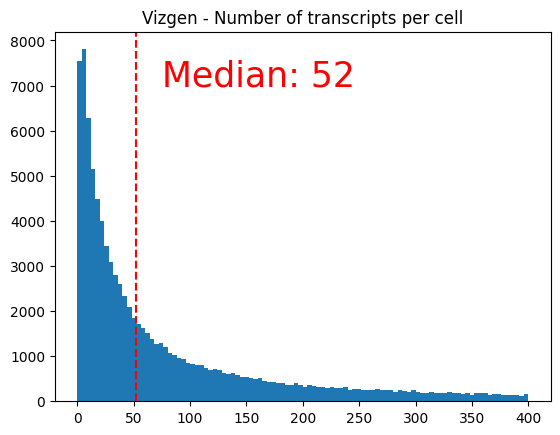

In [28]:
plt.hist(vizgen_transcript_counts_filtered, bins = 100, range = (0,400))
plt.axvline(vizgen_transcript_counts_filtered.median(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(75, 7000, f'Median: {int(vizgen_transcript_counts_filtered.median())}', color = 'red', fontsize = 25)
#plt.axvline(vizgen_transcript_counts.mean() - vizgen_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(420, 100000, f'SD: {int(vizgen_transcript_counts.std())}', color = 'green', fontsize = 15)
#plt.axvline(vizgen_transcript_counts.mean() + vizgen_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Vizgen - Number of transcripts per cell')

In [29]:
vizgen_violin_plot_df = pd.DataFrame()

In [30]:
vizgen_transcript_counts_filtered

cell_id
4407145600021100055      1
4407145600022100261      1
4407145600024100003    409
4407145600024100004    610
4407145600024100005     22
                      ... 
4407145601700100052      1
4407145601700100065      1
4407145601701100007      1
4407145601703100144      1
4407145601704100128      1
Length: 107219, dtype: int64

In [31]:
vizgen_violin_plot_df['transcript_count'] = vizgen_transcript_counts_filtered
vizgen_violin_plot_df['technology'] = 'Vizgen'
vizgen_violin_plot_df

,transcript_count,technology
cell_id,,
4407145600021100055,1,Vizgen
4407145600022100261,1,Vizgen
4407145600024100003,409,Vizgen
4407145600024100004,610,Vizgen
4407145600024100005,22,Vizgen
...,...,...
4407145601700100052,1,Vizgen
4407145601700100065,1,Vizgen
4407145601701100007,1,Vizgen


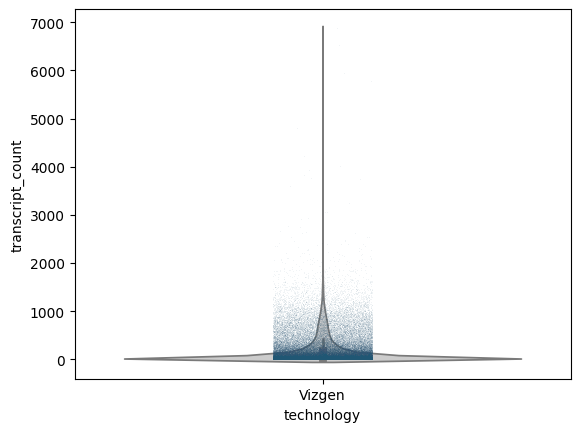

In [32]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = vizgen_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = vizgen_violin_plot_df, jitter = True, size = 0.15)
plt.show()

# Cbm2 Analysis

In [33]:
cbm2_cell_df = pd.read_csv(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\cbm2_single_cell_raw_counts.csv")
cbm2_cell_df = cbm2_cell_df.iloc[:, 1:]
cbm2_cell_df

,4930570B17Rik,Abhd2,Acer3,Acta2,Adcy1,Adcy2,Adgrl3,Agt,Ahcyl2,Aif1l,...,Unc13b,Unc13c,Unc5c,Vim,Vip,Vps13c,Wdr17,Wfs1,Wipf3,Zfp36l1
0,0,0,5,6,17,2,6,83,5,1,...,0,5,0,0,0,3,0,3,4,17
1,0,0,1,0,5,0,11,0,12,0,...,0,1,9,0,0,7,0,6,0,6
2,0,28,0,2,0,0,4,7,2,0,...,0,5,0,10,0,0,0,1,0,14
3,0,7,8,5,12,1,42,31,16,1,...,3,3,8,2,0,33,4,15,6,2
4,0,15,7,2,10,4,28,0,16,0,...,9,0,8,3,0,45,5,11,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58187,0,3,0,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
58188,0,0,0,0,1,3,0,12,0,1,...,0,0,0,0,0,0,0,4,0,0
58189,0,1,0,0,0,2,1,0,0,0,...,0,0,0,0,0,2,0,1,0,0
58190,0,1,0,7,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,2


In [34]:
cbm2_transcript_counts = cbm2_cell_df.sum(axis=1)
cbm2_transcript_counts_revised = cbm2_transcript_counts[cbm2_transcript_counts != 0]
cbm2_transcript_counts_revised

0        1788
1        1018
2         959
3        3963
4        2720
         ... 
58187     160
58188     297
58189     125
58190     114
58191      76
Length: 58191, dtype: int64

In [35]:
print(f'Cbm2 median transcript count: {cbm2_transcript_counts_revised.median()}')
print(f'Cbm2 min transcript count: {cbm2_transcript_counts_revised.min()}')
print(f'Cbm2 max transcript count: {cbm2_transcript_counts_revised.max()}')

Cbm2 median transcript count: 1161.0
Cbm2 min transcript count: 1
Cbm2 max transcript count: 8552


Text(0.5, 1.0, 'Cbm2 - Number of transcripts per cell')

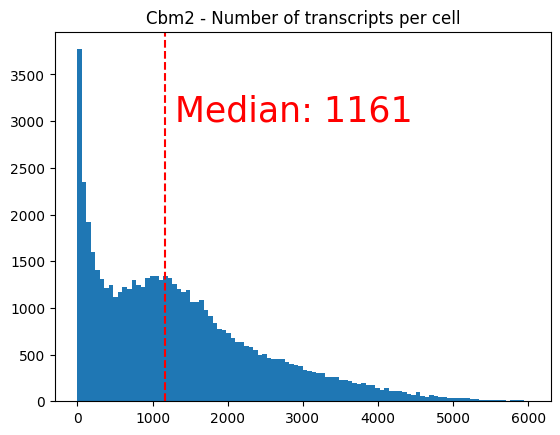

In [36]:
plt.hist(cbm2_transcript_counts_revised, bins = 100, range = (0,6000))
plt.axvline(cbm2_transcript_counts_revised.median(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(1300, 3000, f'Median: {int(cbm2_transcript_counts_revised.median())}', color = 'red', fontsize = 25)
#plt.axvline(cbm2_transcript_counts.mean() - cbm2_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(2570, 3500, f'SD: {int(cbm2_transcript_counts.std())}', color = 'green', fontsize = 15)
#plt.axvline(cbm2_transcript_counts.mean() + cbm2_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Cbm2 - Number of transcripts per cell')

In [37]:
cbm2_violin_plot_df = pd.DataFrame()

In [38]:
cbm2_violin_plot_df['transcript_count'] = cbm2_transcript_counts_revised
cbm2_violin_plot_df['technology'] = 'Cbm2'
cbm2_violin_plot_df

,transcript_count,technology
0,1788,Cbm2
1,1018,Cbm2
2,959,Cbm2
3,3963,Cbm2
4,2720,Cbm2
...,...,...
58187,160,Cbm2
58188,297,Cbm2
58189,125,Cbm2
58190,114,Cbm2


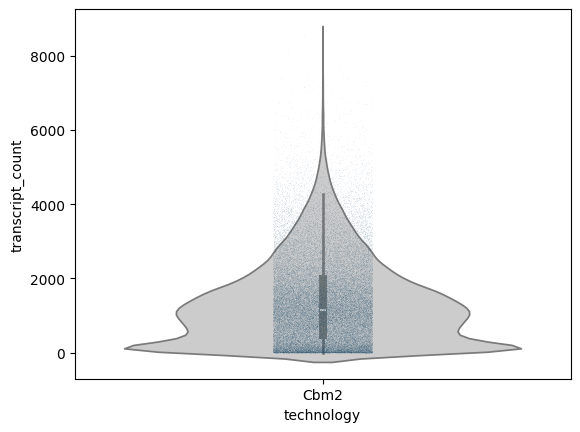

In [39]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = cbm2_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = cbm2_violin_plot_df, jitter = True, size = 0.15)
plt.show()

### Generate violin plot for all genes

In [40]:
concated_violin_plot_df = pd.DataFrame()

In [41]:
concated_violin_plot_df = pd.concat([xenium_violin_plot_df, cosmx_violin_plot_df, vizgen_violin_plot_df, cbm2_violin_plot_df], ignore_index = True)
concated_violin_plot_df

,transcript_count,technology
0,4,Xenium
1,12,Xenium
2,34,Xenium
3,3,Xenium
4,6,Xenium
...,...,...
853345,160,Cbm2
853346,297,Cbm2
853347,125,Cbm2
853348,114,Cbm2


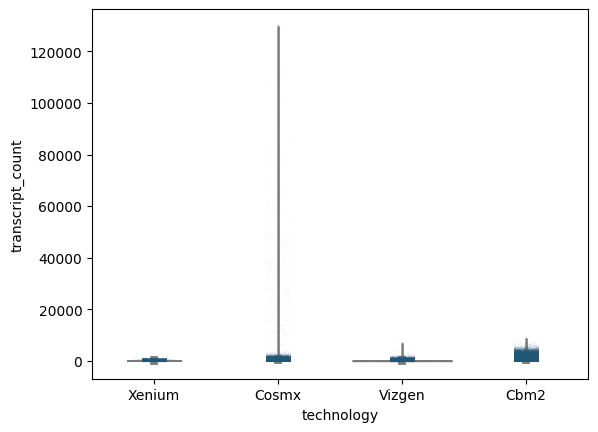

In [42]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = concated_violin_plot_df, jitter = True, size = 0.15)
plt.show()

In [43]:
gene_overlap_list = ['Acta2',
 'Aqp4',
 'Bdnf',
 'Calb1',
 'Cldn5',
 'Fos',
 'Gad1',
 'Gfap',
 'Gpr17',
 'Npy2r',
 'Pdgfra',
 'Vip']

# Xenium overlap

In [44]:
xenium_scdata = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Xenium_mouse_filtered.h5ad")

In [45]:
xenium_cell_df = pd.DataFrame(columns = xenium_scdata.var.index)
for sample in sample_id_list:
    mtx = sc.read_10x_h5(rf"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\xenium_prerelease_molina_mouse_brain_Mar13\{sample}\cell_feature_matrix.h5")
    xenium_cell_df = pd.concat([xenium_cell_df, pd.DataFrame(mtx.X.toarray(), columns = xenium_scdata.var.index)], ignore_index = True)

In [46]:
xenium_overlap = xenium_cell_df.loc[:, [gene for gene in xenium_cell_df.columns if gene in gene_overlap_list]]
xenium_overlap_filtered = xenium_overlap[xenium_overlap.sum(axis = 1) != 0]
xenium_overlap_filtered

,Acta2,Aqp4,Bdnf,Calb1,Cldn5,Fos,Gad1,Gfap,Gpr17,Npy2r,Pdgfra,Vip
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,1.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
556311,0.0,0.0,0.0,1.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
556312,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0
556313,0.0,0.0,0.0,2.0,6.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
556314,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


In [47]:
cosmx_overlap = cosmx_gene_exp_revised.loc[:, [gene for gene in cosmx_gene_exp_revised.columns if gene in gene_overlap_list]]
cosmx_overlap_filtered = cosmx_overlap[cosmx_overlap.sum(axis=1) != 0]
cosmx_overlap_filtered

,Pdgfra,Gad1,Vip,Cldn5,Calb1,Npy2r,Fos,Gpr17,Acta2,Gfap,Bdnf,Aqp4
0,6,22,9,12,14,12,13,18,7,51,15,34
5,0,0,0,0,0,0,0,1,0,0,0,0
6,1,0,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
134760,0,1,0,0,0,0,0,0,0,1,1,0
134764,0,1,0,0,0,0,0,0,0,0,0,0
134770,1,0,0,0,0,0,1,0,0,0,0,0
134771,0,0,0,0,0,0,0,1,0,1,0,0


In [48]:
vizgen_overlap = vizgen_concat.loc[:, [gene for gene in vizgen_concat.columns if gene in gene_overlap_list]]
vizgen_overlap_filtered = vizgen_overlap[vizgen_overlap.sum(axis=1) != 0]
vizgen_overlap_filtered

gene,Acta2,Aqp4,Bdnf,Calb1,Cldn5,Fos,Gad1,Gfap,Gpr17,Npy2r,Pdgfra,Vip
cell_id,,,,,,,,,,,,
4407145600024100003,0,0,0,0,0,0,1,0,1,0,0,1
4407145600024100004,0,0,5,2,0,5,1,0,0,0,0,0
4407145600024100007,0,0,0,3,0,0,0,0,0,0,0,0
4407145600024100008,1,0,4,0,1,1,1,0,0,0,0,0
4407145600024100013,0,0,0,0,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4407145601618100034,0,0,0,0,0,0,0,1,0,0,0,0
4407145601618100038,0,1,0,0,0,0,0,2,0,0,0,0
4407145601618100043,0,1,0,0,0,0,0,0,0,0,0,0


In [49]:
cbm2_overlap = cbm2_cell_df.loc[:, [gene for gene in cbm2_cell_df.columns if gene in gene_overlap_list]]
cbm2_overlap_filtered = cbm2_overlap[cbm2_overlap.sum(axis=1) != 0]
cbm2_overlap_filtered

,Acta2,Aqp4,Bdnf,Calb1,Cldn5,Fos,Gad1,Gfap,Gpr17,Npy2r,Pdgfra,Vip
0,6,17,0,2,0,1,0,0,0,0,0,0
1,0,0,0,8,0,0,0,0,1,2,0,0
2,2,1,1,1,40,0,0,1,0,1,0,0
3,5,3,7,34,1,2,1,2,4,2,3,0
4,2,0,4,14,0,8,0,1,2,14,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58184,0,0,0,1,0,0,0,0,0,0,1,0
58185,0,0,0,1,0,0,0,0,0,0,1,0
58187,0,0,0,0,0,0,1,0,1,0,0,0
58188,0,3,0,3,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Xenium Overlap - Number of Transcripts per cell')

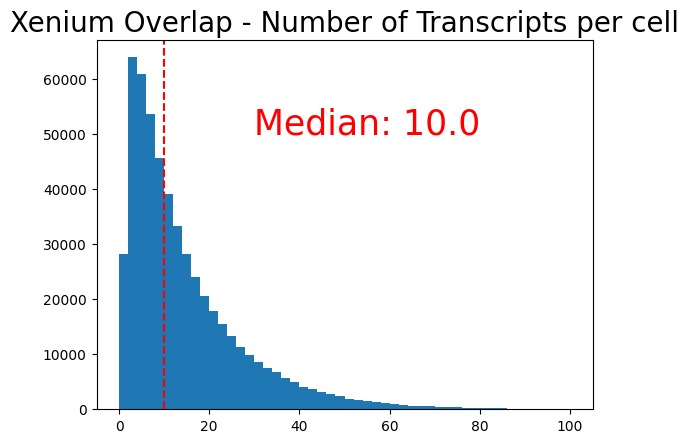

In [50]:
xenium_overlap_transcripts = xenium_overlap_filtered.sum(axis = 1)
plt.hist(xenium_overlap_transcripts, bins = 50, range = (0,100))
plt.axvline(xenium_overlap_transcripts.median(), color = 'red', linestyle = 'dashed', label = 'Median')
plt.text(30, 50000, f'Median: {xenium_overlap_transcripts.median()}', color = 'red', fontsize = 25)
plt.title('Xenium Overlap - Number of Transcripts per cell', fontsize = 20)

In [51]:
xenium_overlap_violin_plot_df = pd.DataFrame()

In [52]:
xenium_overlap_violin_plot_df['transcript_count'] = xenium_overlap_transcripts
xenium_overlap_violin_plot_df['technology'] = 'Xenium'
xenium_overlap_violin_plot_df

,transcript_count,technology
6,2.0,Xenium
7,11.0,Xenium
8,1.0,Xenium
11,1.0,Xenium
15,2.0,Xenium
...,...,...
556311,9.0,Xenium
556312,11.0,Xenium
556313,11.0,Xenium
556314,7.0,Xenium


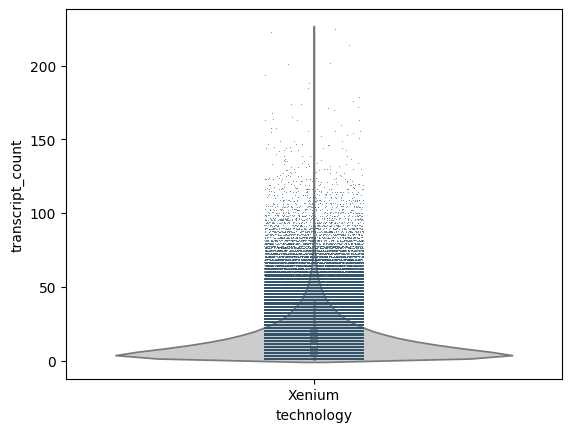

In [53]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = xenium_overlap_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = xenium_overlap_violin_plot_df, jitter = True, size = 0.5)
plt.show()

Text(0.5, 1.0, 'Cosmx Overlap - Number of Transcripts per cell')

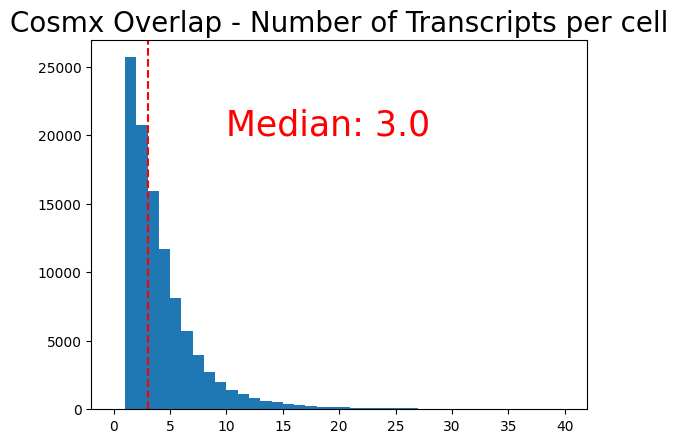

In [54]:
cosmx_overlap_transcripts = cosmx_overlap_filtered.sum(axis = 1)
plt.hist(cosmx_overlap_transcripts, bins = 40, range = (0,40))
plt.axvline(cosmx_overlap_transcripts.median(), color = 'red', linestyle = 'dashed', label = 'Median')
plt.text(10, 20000, f'Median: {cosmx_overlap_transcripts.median()}', color = 'red', fontsize = 25)
plt.title('Cosmx Overlap - Number of Transcripts per cell', fontsize = 20)

In [55]:
cosmx_overlap_violin_plot_df = pd.DataFrame()

In [56]:
cosmx_overlap_violin_plot_df['transcript_count'] = cosmx_overlap_transcripts
cosmx_overlap_violin_plot_df['technology'] = 'Cosmx'
cosmx_overlap_violin_plot_df

,transcript_count,technology
0,213,Cosmx
5,1,Cosmx
6,2,Cosmx
7,1,Cosmx
8,1,Cosmx
...,...,...
134760,3,Cosmx
134764,1,Cosmx
134770,2,Cosmx
134771,2,Cosmx


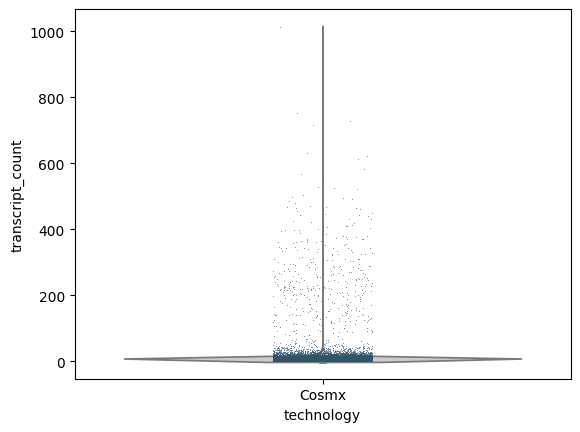

In [57]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = cosmx_overlap_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = cosmx_overlap_violin_plot_df, jitter = True, size = 0.5)
plt.show()

Text(0.5, 1.0, 'Vizgen Overlap - Number of Transcripts per cell')

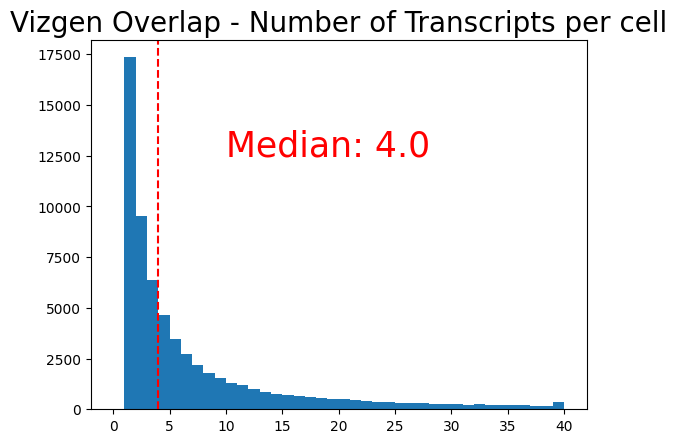

In [58]:
vizgen_overlap_transcripts = vizgen_overlap_filtered.sum(axis = 1)
plt.hist(vizgen_overlap_transcripts, bins = 40, range = (0,40))
plt.axvline(vizgen_overlap_transcripts.median(), color = 'red', linestyle = 'dashed', label = 'Median')
plt.text(10, 12500, f'Median: {vizgen_overlap_transcripts.median()}', color = 'red', fontsize = 25)
plt.title('Vizgen Overlap - Number of Transcripts per cell', fontsize = 20)

In [59]:
vizgen_overlap_violin_plot_df = pd.DataFrame()

In [60]:
vizgen_overlap_violin_plot_df['transcript_count'] = vizgen_overlap_transcripts
vizgen_overlap_violin_plot_df['technology'] = 'Vizgen'
vizgen_overlap_violin_plot_df

,transcript_count,technology
cell_id,,
4407145600024100003,3,Vizgen
4407145600024100004,13,Vizgen
4407145600024100007,3,Vizgen
4407145600024100008,8,Vizgen
4407145600024100013,3,Vizgen
...,...,...
4407145601618100034,1,Vizgen
4407145601618100038,3,Vizgen
4407145601618100043,1,Vizgen


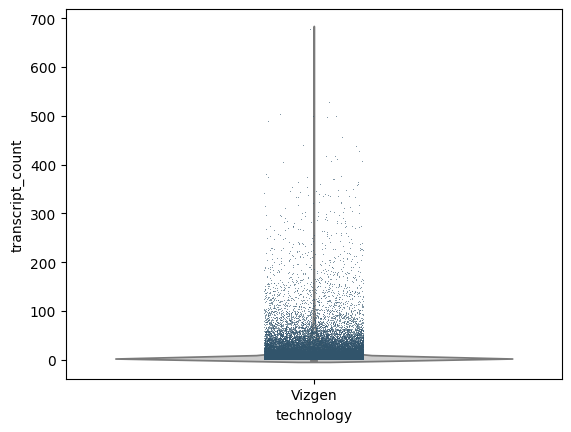

In [61]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = vizgen_overlap_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = vizgen_overlap_violin_plot_df, jitter = True, size = 0.5)
plt.show()

Text(0.5, 1.0, 'Cbm2 Overlap - Number of Transcripts per cell')

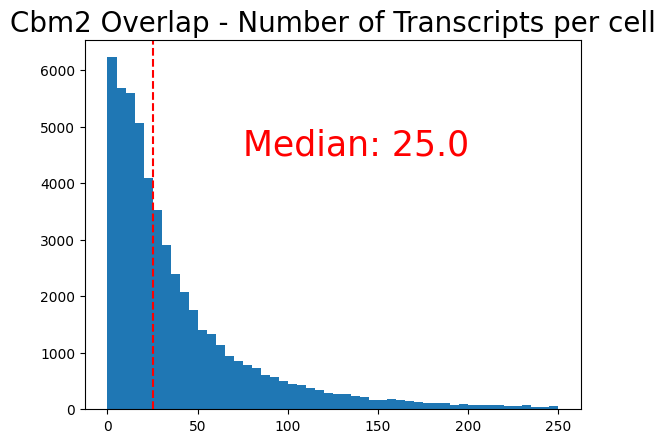

In [62]:
cbm2_overlap_transcripts = cbm2_overlap_filtered.sum(axis = 1)
plt.hist(cbm2_overlap_transcripts, bins = 50, range = (0,250))
plt.axvline(cbm2_overlap_transcripts.median(), color = 'red', linestyle = 'dashed', label = 'Median')
plt.text(75, 4500, f'Median: {cbm2_overlap_transcripts.median()}', color = 'red', fontsize = 25)
plt.title('Cbm2 Overlap - Number of Transcripts per cell', fontsize = 20)

In [63]:
cbm2_overlap_violin_plot_df = pd.DataFrame()

In [64]:
cbm2_overlap_violin_plot_df['transcript_count'] = cbm2_overlap_transcripts
cbm2_overlap_violin_plot_df['technology'] = 'Cbm2'
cbm2_overlap_violin_plot_df

,transcript_count,technology
0,26,Cbm2
1,11,Cbm2
2,47,Cbm2
3,64,Cbm2
4,47,Cbm2
...,...,...
58184,2,Cbm2
58185,2,Cbm2
58187,2,Cbm2
58188,6,Cbm2


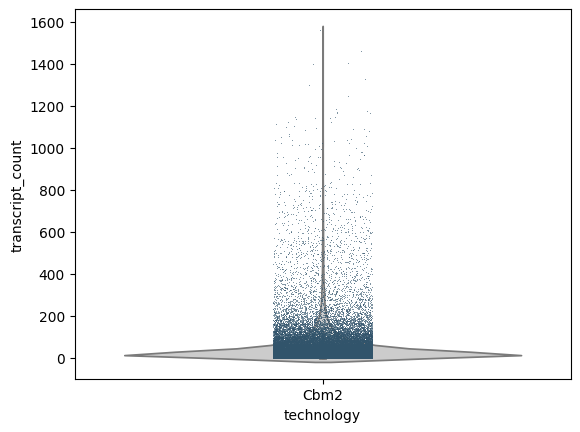

In [65]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = cbm2_overlap_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = cbm2_overlap_violin_plot_df, jitter = True, size = 0.5)
plt.show()

### Violin plot based on overlap genes

In [66]:
concated_overlap_violin_plot_df = pd.DataFrame()

In [67]:
concated_overlap_violin_plot_df = pd.concat([xenium_overlap_violin_plot_df, cosmx_overlap_violin_plot_df, vizgen_overlap_violin_plot_df, cbm2_overlap_violin_plot_df], ignore_index = True)
concated_overlap_violin_plot_df

,transcript_count,technology
0,2.0,Xenium
1,11.0,Xenium
2,1.0,Xenium
3,1.0,Xenium
4,2.0,Xenium
...,...,...
755637,2.0,Cbm2
755638,2.0,Cbm2
755639,2.0,Cbm2
755640,6.0,Cbm2


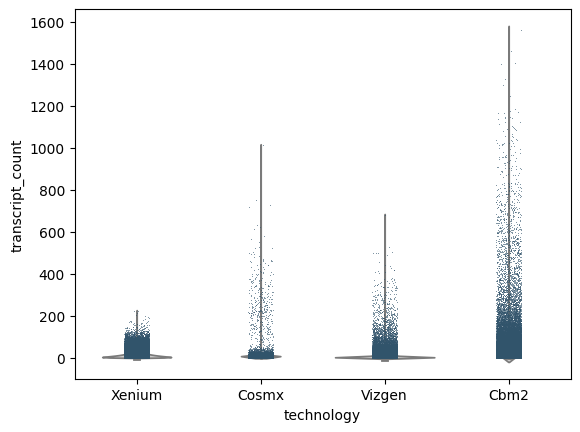

In [68]:
sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_overlap_violin_plot_df, color = '0.8')
sns.stripplot(x = 'technology', y = 'transcript_count', data = concated_overlap_violin_plot_df, jitter = True, size = 0.5)
plt.show()

### Histograms for overlapping genes individually

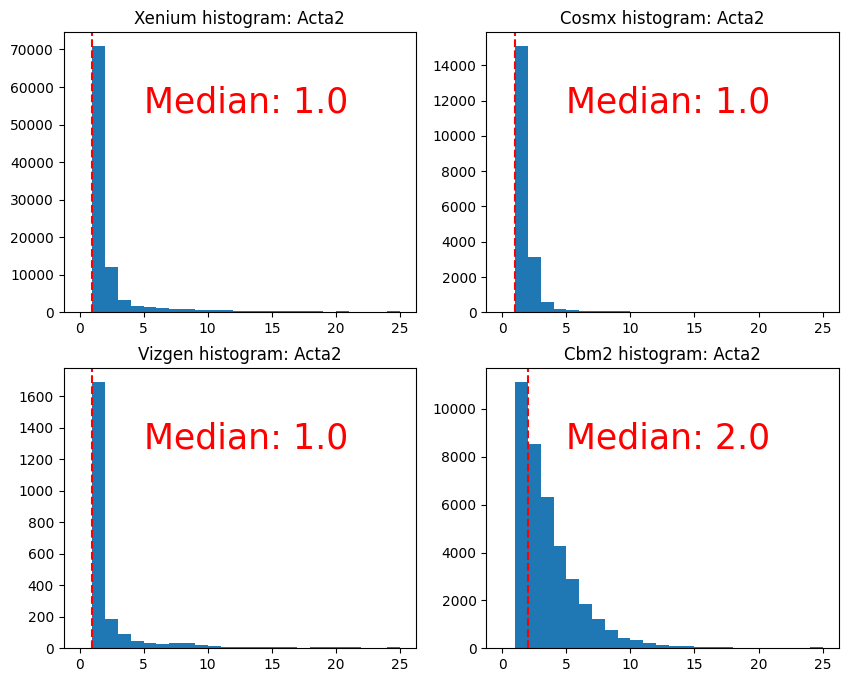

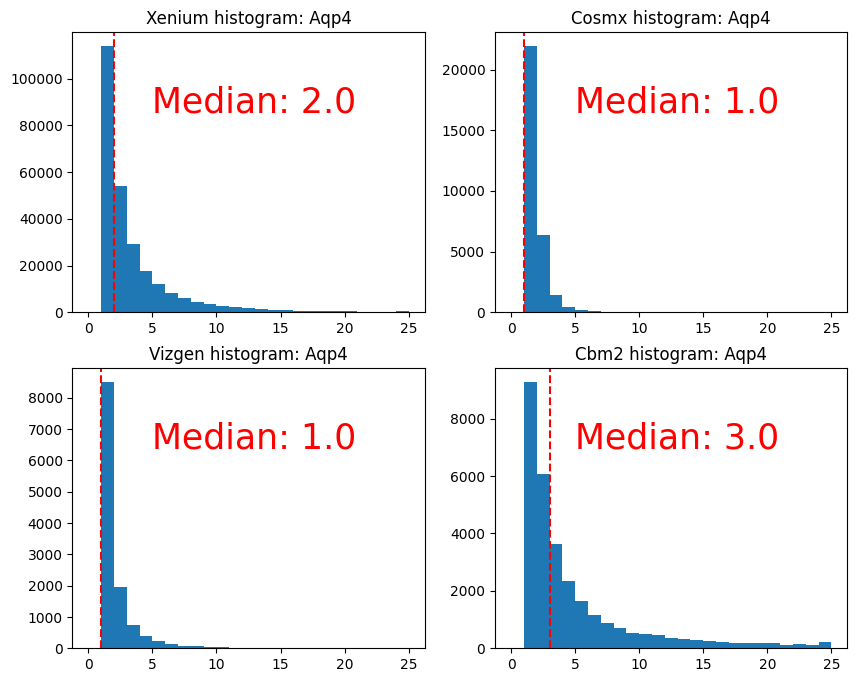

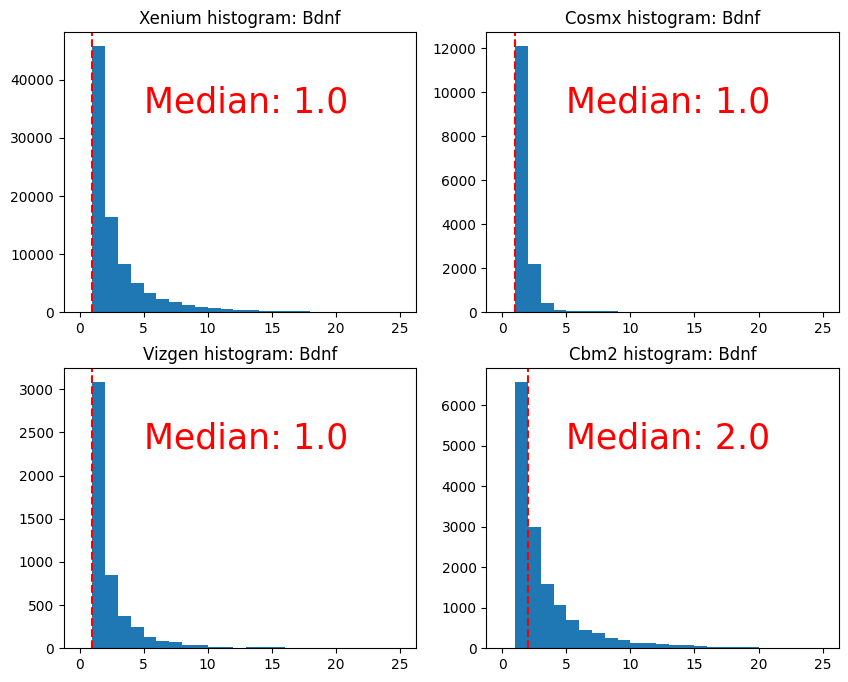

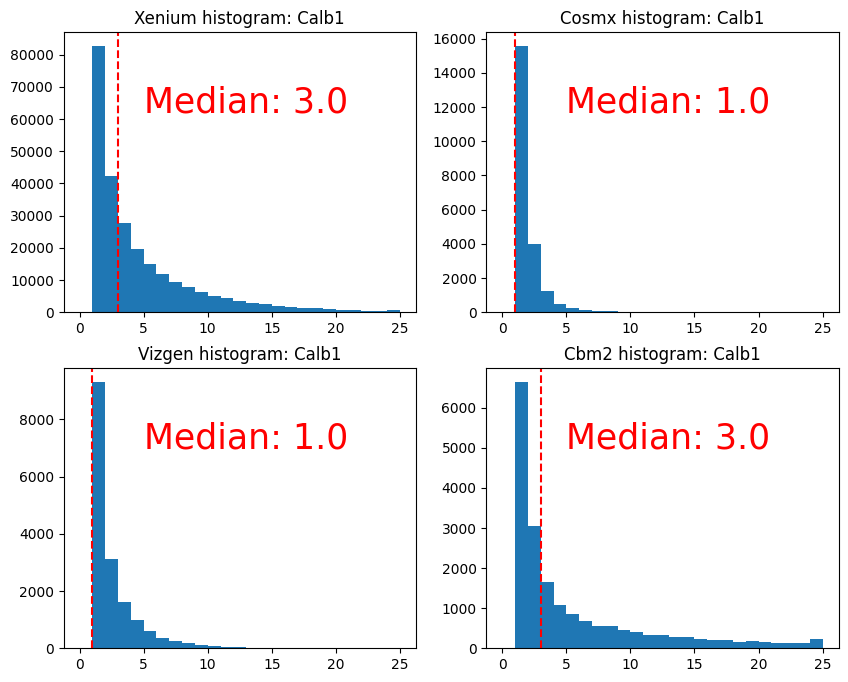

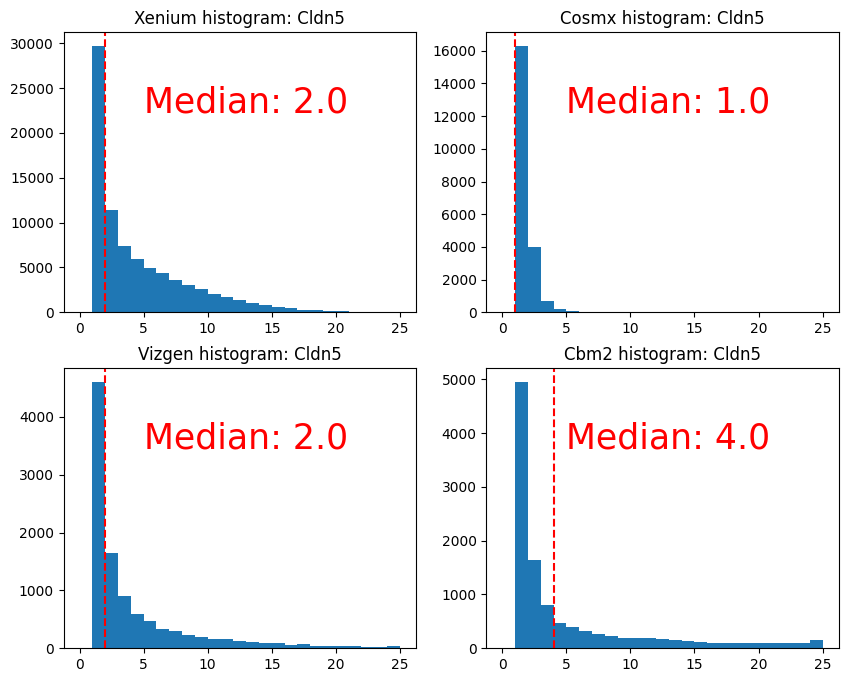

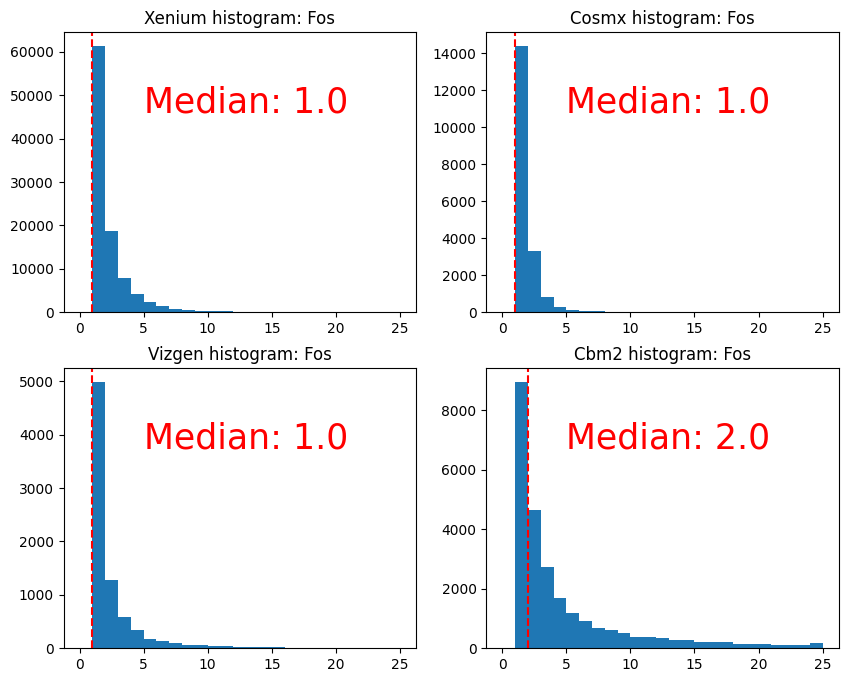

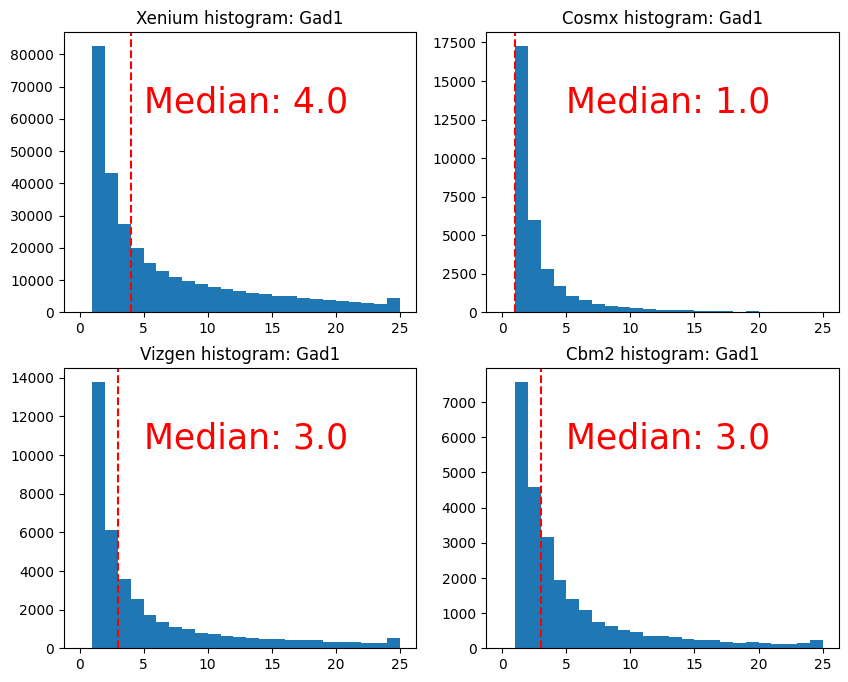

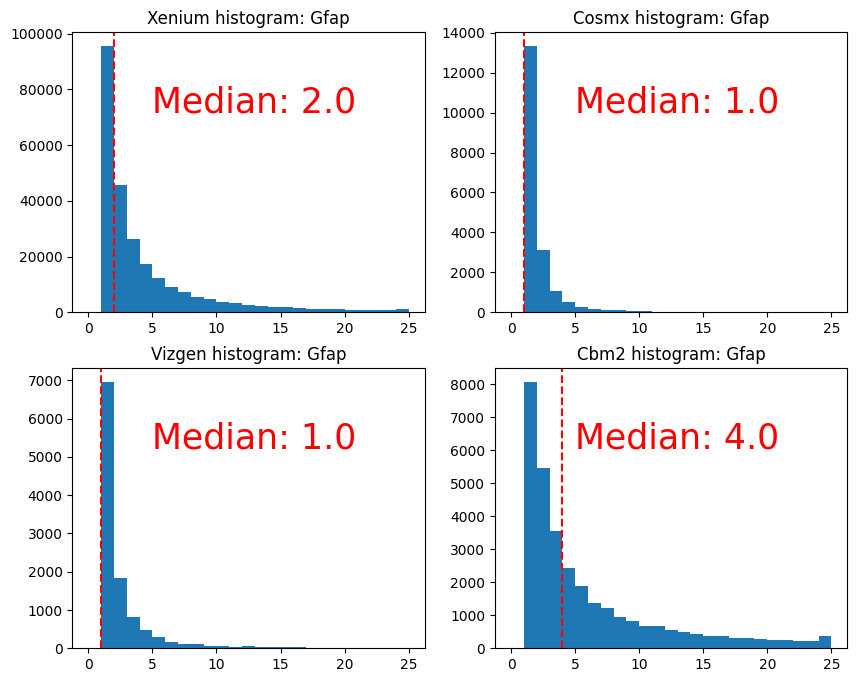

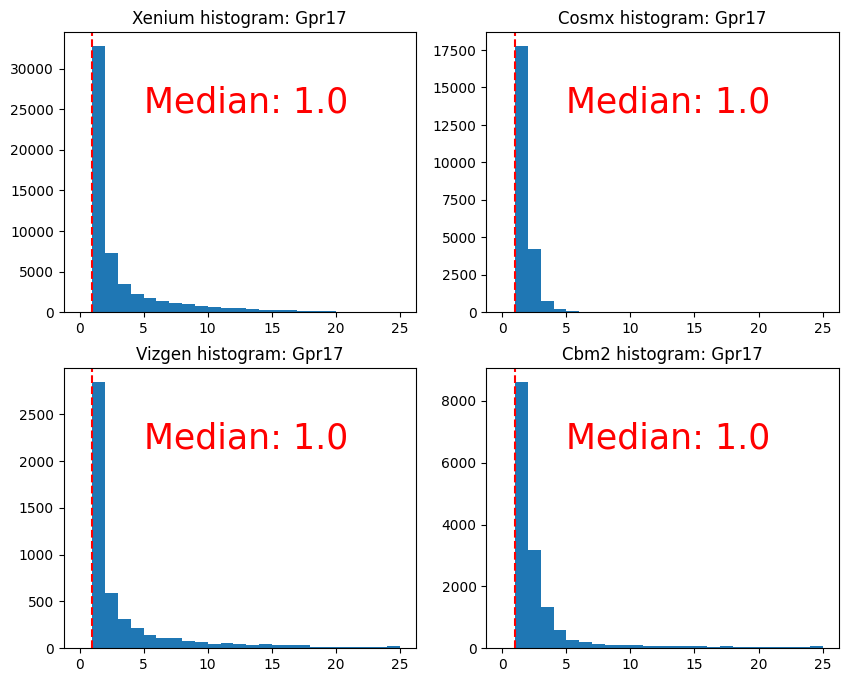

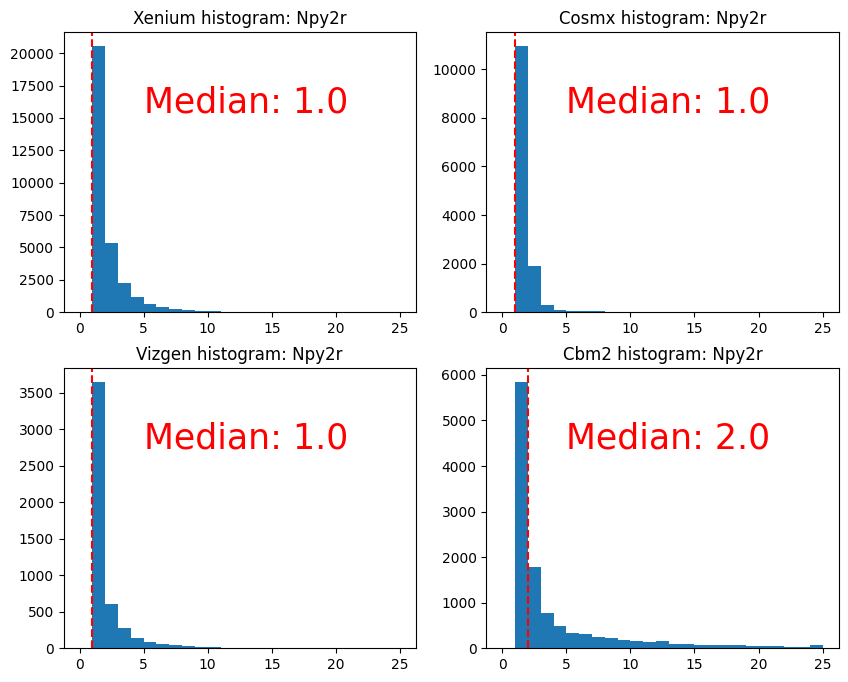

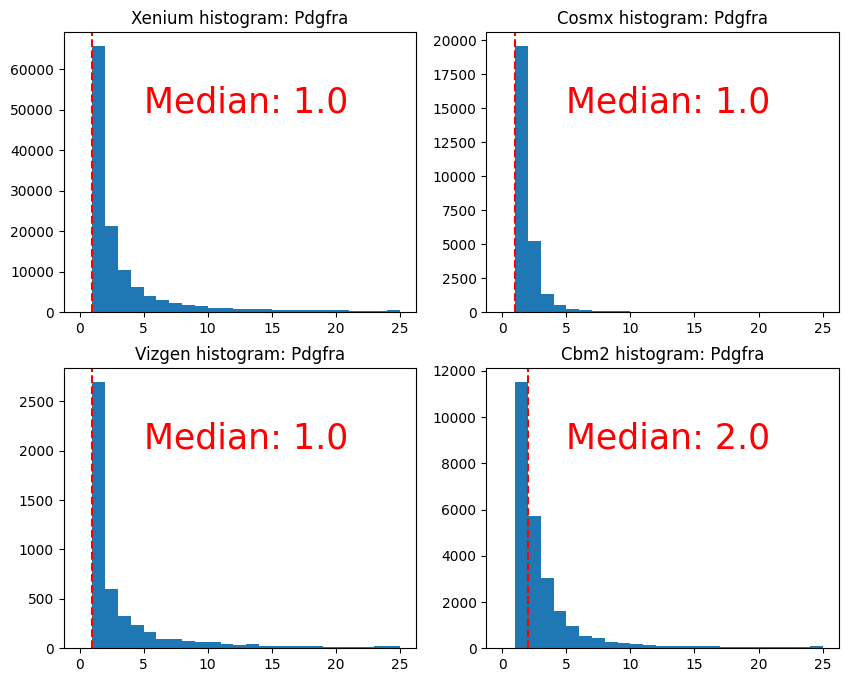

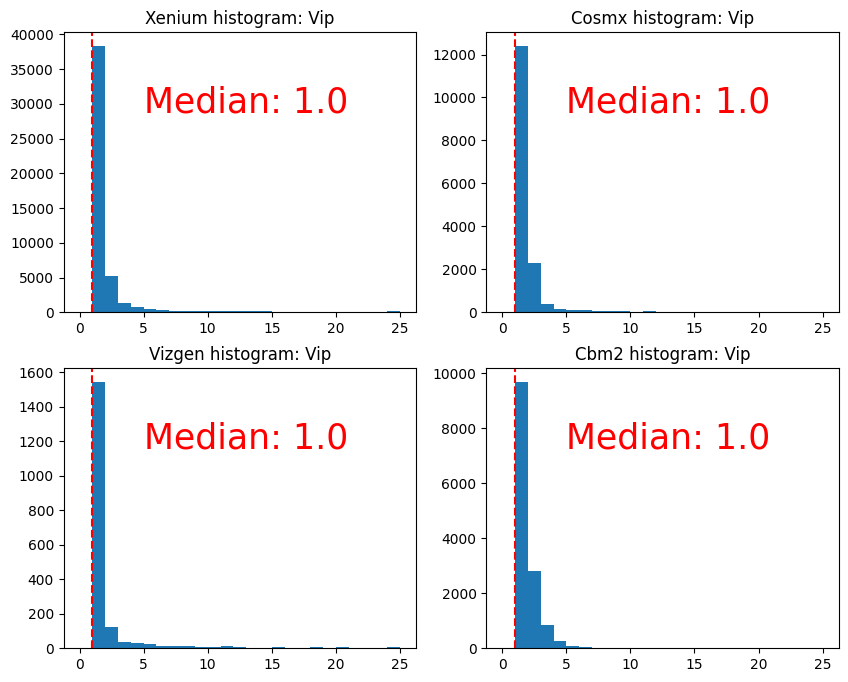

In [69]:
for gene in gene_overlap_list:
    xenium_overlap_filtered_gene = xenium_overlap_filtered[gene][xenium_overlap_filtered[gene] != 0]
    cosmx_overlap_filtered_gene = cosmx_overlap_filtered[gene][cosmx_overlap_filtered[gene] != 0]
    vizgen_overlap_filtered_gene = vizgen_overlap_filtered[gene][vizgen_overlap_filtered[gene] != 0]
    cbm2_overlap_filtered_gene = cbm2_overlap_filtered[gene][cbm2_overlap_filtered[gene] != 0]
    fig, axs = plt.subplots(2,2, figsize = (10,8))
    counts, bins, _ = axs[0,0].hist(xenium_overlap_filtered_gene, bins = 25, range = (0,25))
    axs[0,0].axvline(xenium_overlap_filtered_gene.median(), color = 'red', linestyle = 'dashed', label = 'Median')
    axs[0,0].text(5, int(0.75 * np.max(counts)), f'Median: {xenium_overlap_filtered_gene.median()}', color = 'red', fontsize = 25)
    axs[0,0].set_title(f'Xenium histogram: {gene}')
    
    counts, bins, _ = axs[0,1].hist(cosmx_overlap_filtered_gene, bins = 25, range = (0,25))
    axs[0,1].axvline(cosmx_overlap_filtered_gene.median(), color = 'red', linestyle = 'dashed', label = 'Median')
    axs[0,1].text(5, int(0.75 * np.max(counts)), f'Median: {cosmx_overlap_filtered_gene.median()}', color = 'red', fontsize = 25)
    axs[0,1].set_title(f'Cosmx histogram: {gene}')
    
    counts, bins, _ = axs[1,0].hist(vizgen_overlap_filtered_gene, bins = 25, range = (0,25))
    axs[1,0].axvline(vizgen_overlap_filtered_gene.median(), color = 'red', linestyle = 'dashed', label = 'Median')
    axs[1,0].text(5, int(0.75 * np.max(counts)), f'Median: {vizgen_overlap_filtered_gene.median()}', color = 'red', fontsize = 25)
    axs[1,0].set_title(f'Vizgen histogram: {gene}')
    
    counts, bins, _ = axs[1,1].hist(cbm2_overlap_filtered_gene, bins = 25, range = (0,25))
    axs[1,1].axvline(cbm2_overlap_filtered_gene.median(), color = 'red', linestyle = 'dashed', label = 'Median')
    axs[1,1].text(5, int(0.75 * np.max(counts)), f'Median: {cbm2_overlap_filtered_gene.median()}', color = 'red', fontsize = 25)
    axs[1,1].set_title(f'Cbm2 histogram: {gene}')
    plt.show()
    #plt.text(50, 15000, f'Median: {int(vizgen_transcript_counts.median())}', color = 'red', fontsize = 25)
    #plt.axvline(vizgen_transcript_counts.mean() - vizgen_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
    #plt.text(420, 100000, f'SD: {int(vizgen_transcript_counts.std())}', color = 'green', fontsize = 15)
    #plt.axvline(vizgen_transcript_counts.mean() + vizgen_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
    #plt.title('Vizgen - Number of transcripts per cell')

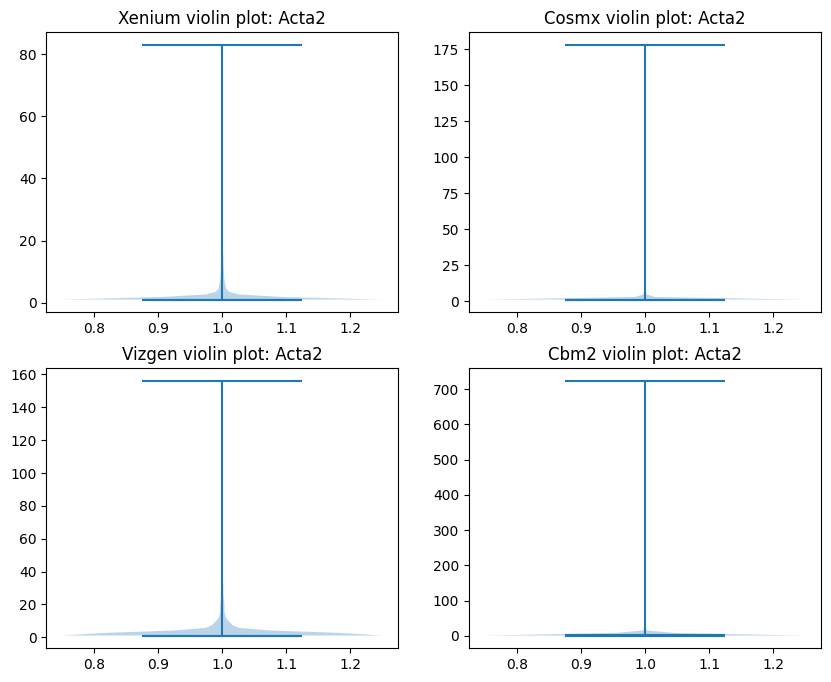

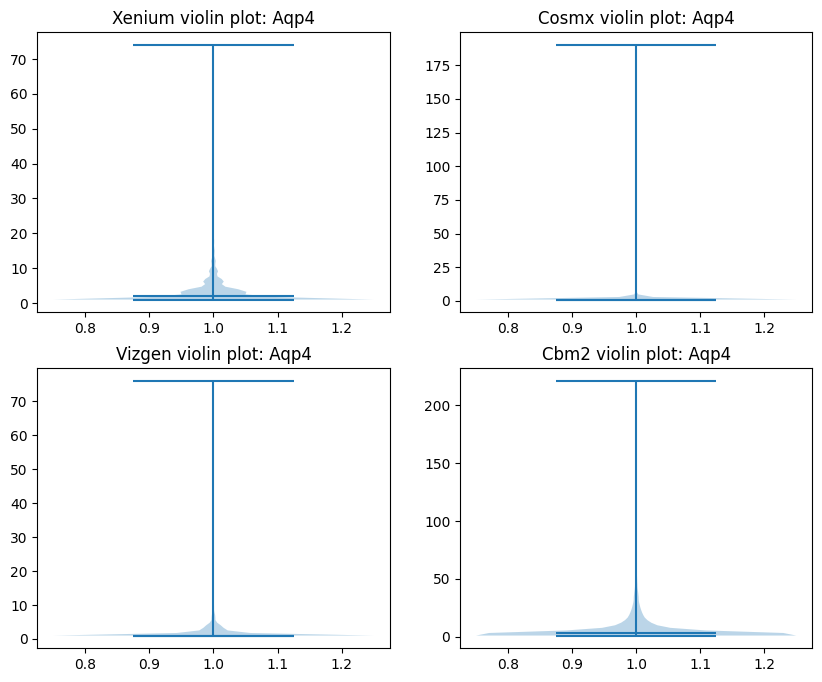

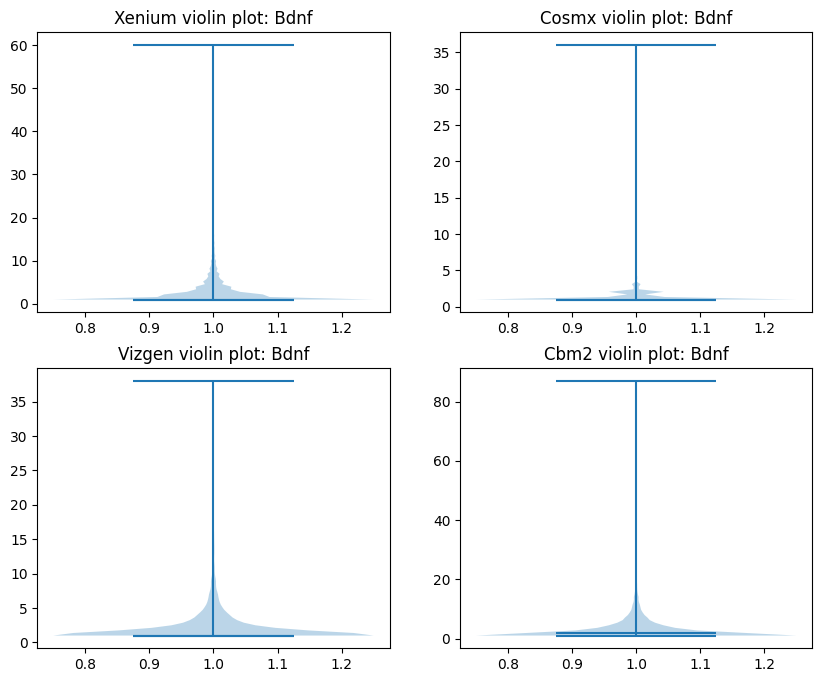

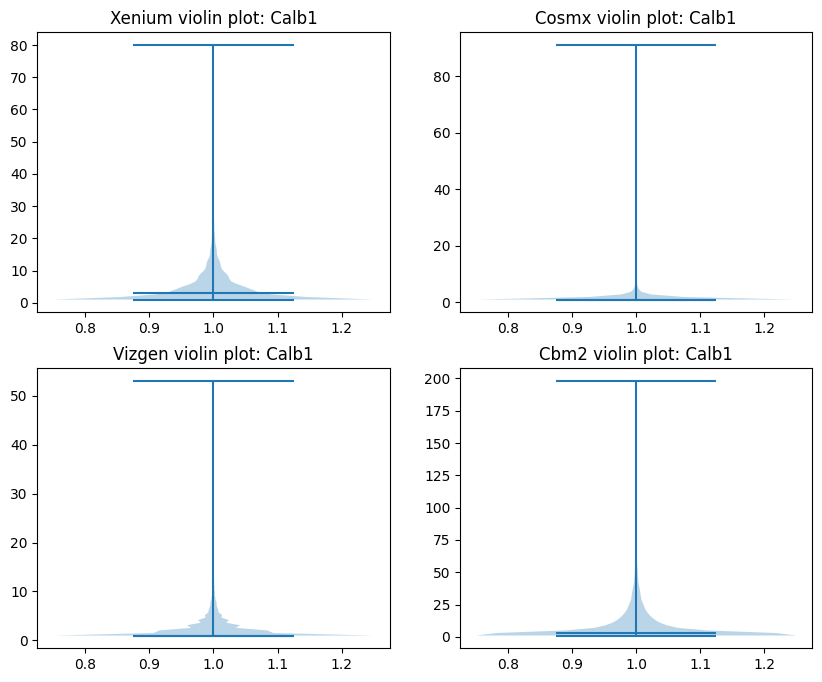

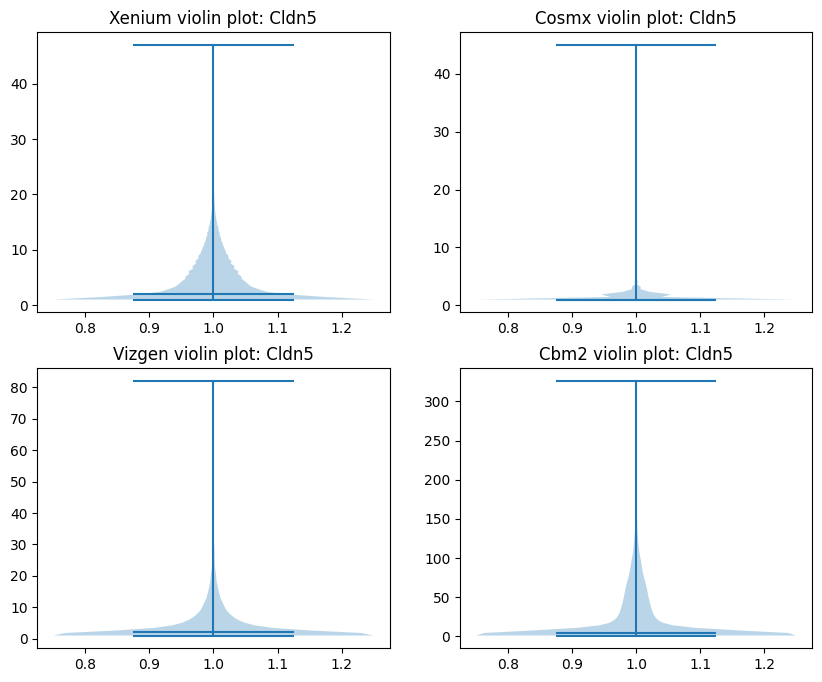

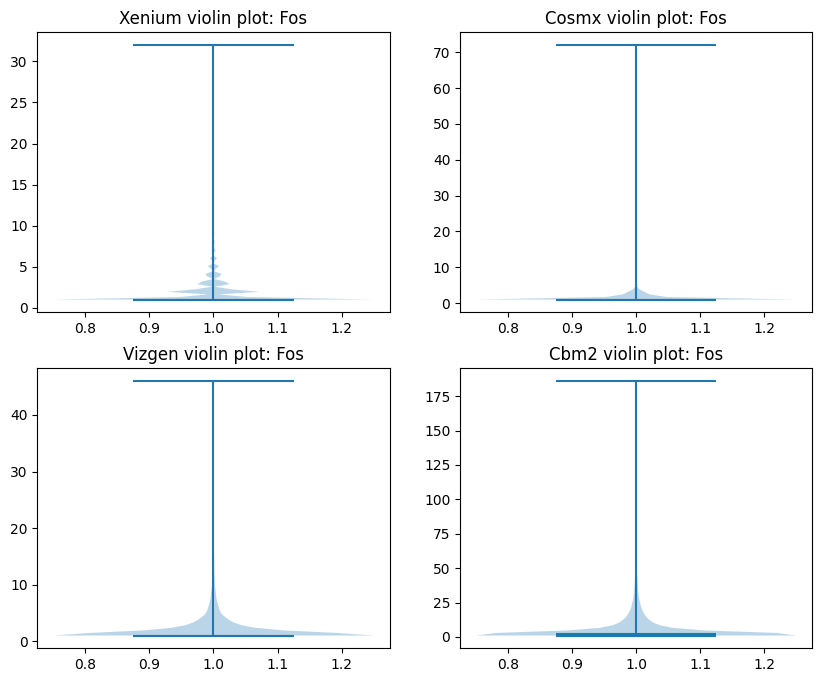

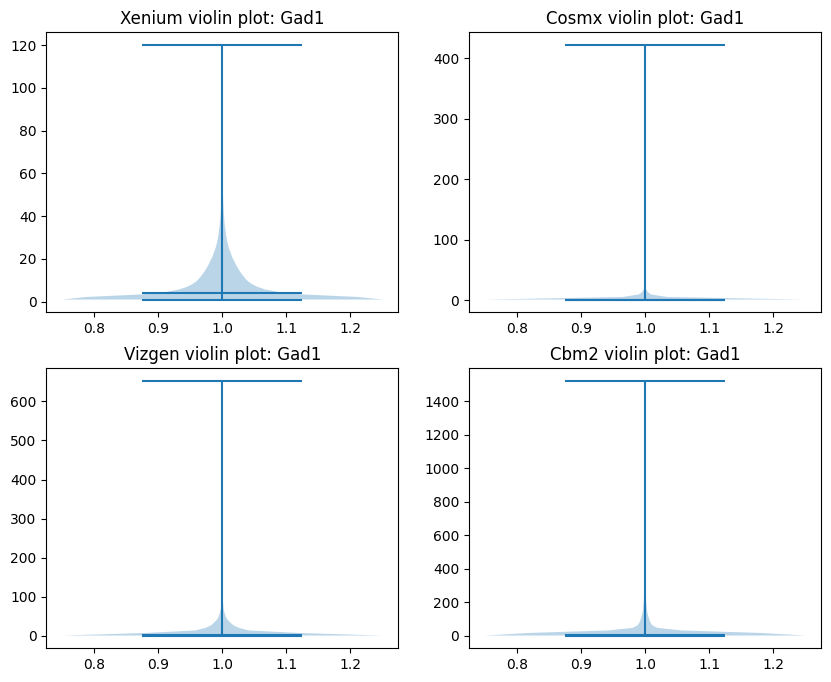

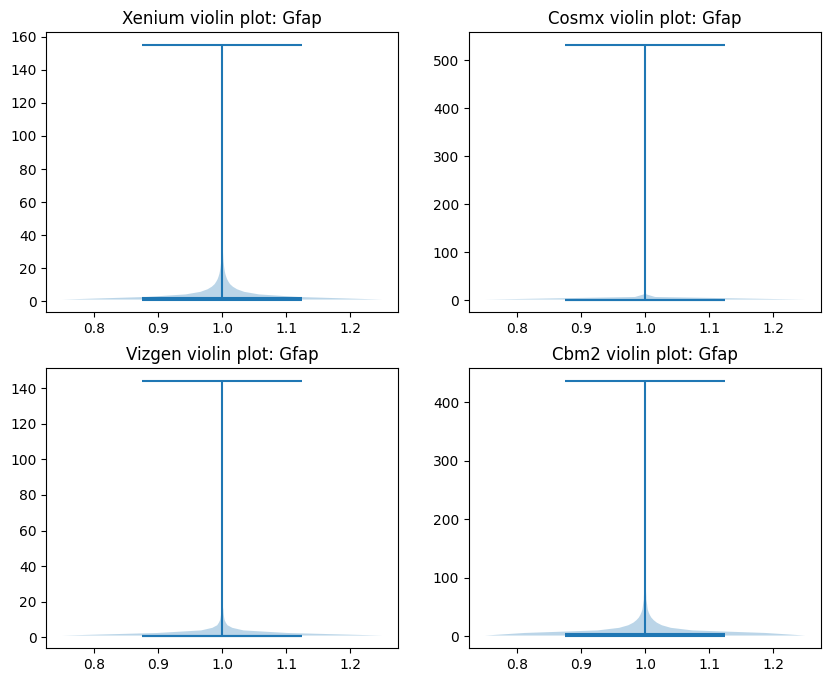

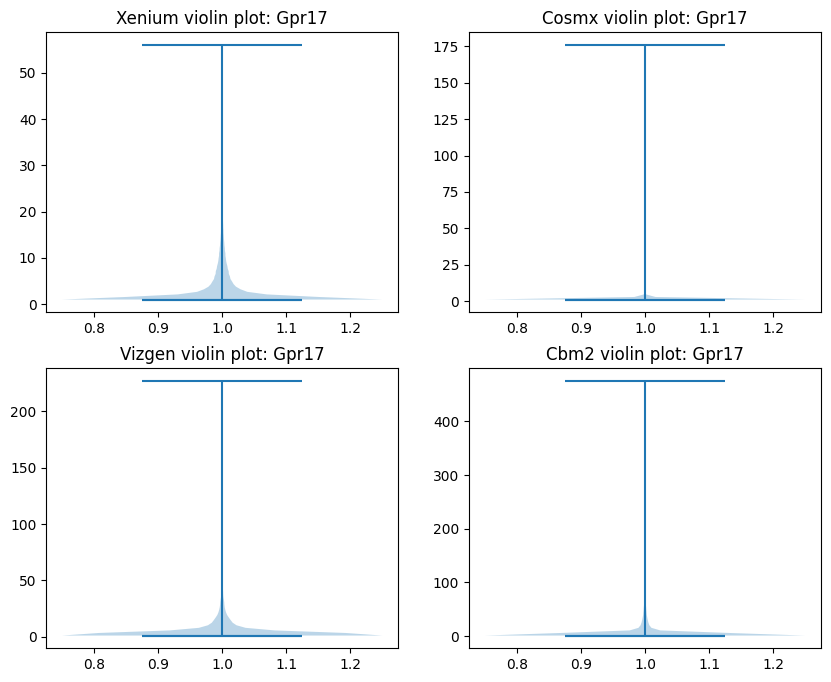

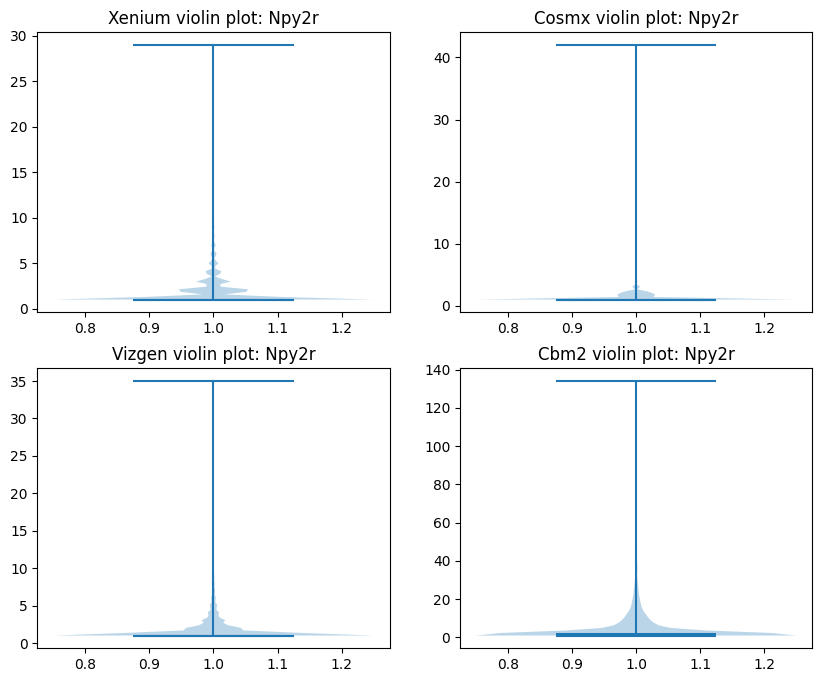

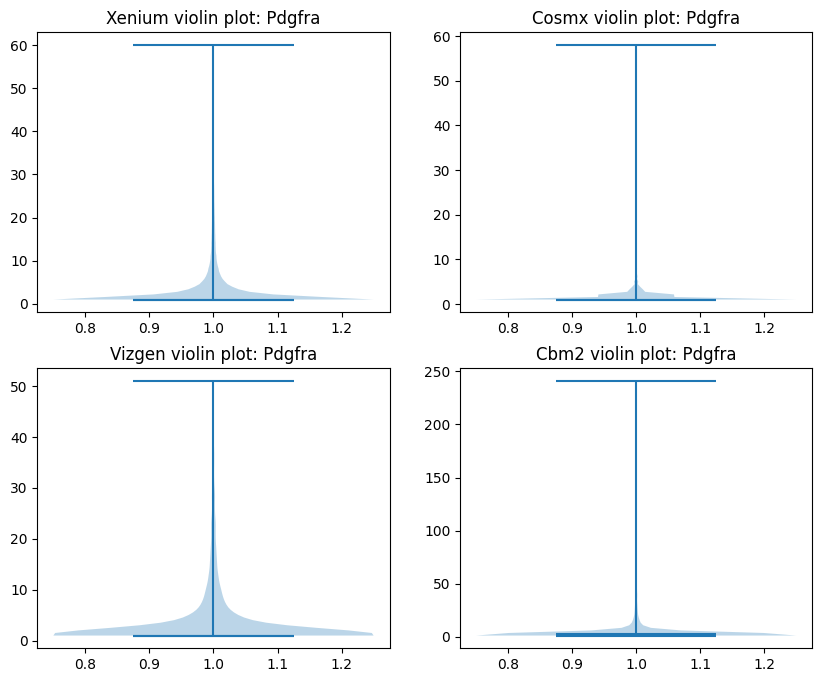

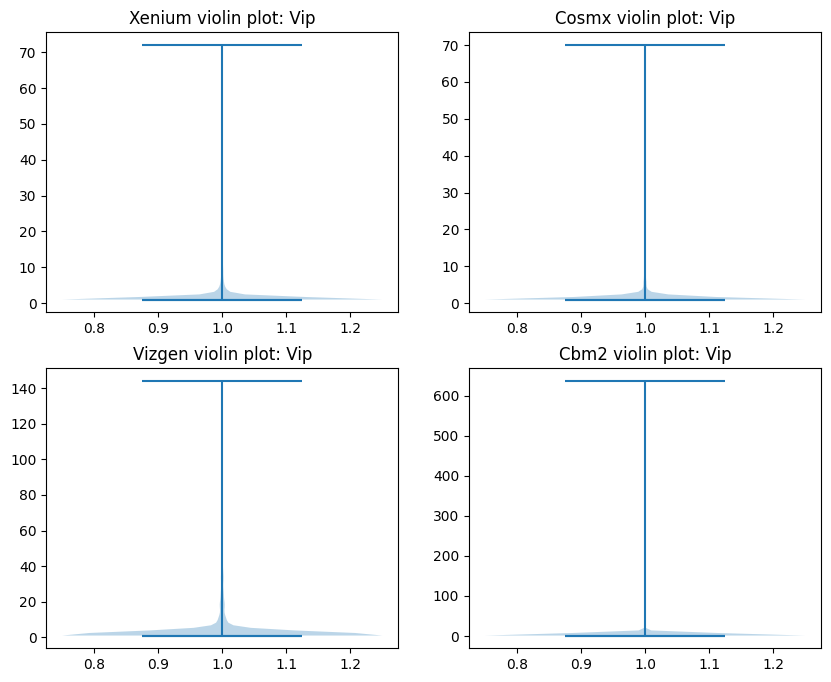

In [70]:
for gene in gene_overlap_list:
    xenium_overlap_filtered_gene = xenium_overlap_filtered[gene][xenium_overlap_filtered[gene] != 0]
    cosmx_overlap_filtered_gene = cosmx_overlap_filtered[gene][cosmx_overlap_filtered[gene] != 0]
    vizgen_overlap_filtered_gene = vizgen_overlap_filtered[gene][vizgen_overlap_filtered[gene] != 0]
    cbm2_overlap_filtered_gene = cbm2_overlap_filtered[gene][cbm2_overlap_filtered[gene] != 0]
    fig, axs = plt.subplots(2,2, figsize = (10,8))
    axs[0,0].violinplot(xenium_overlap_filtered_gene, showmedians = True)
    #axs[0,0].axvline(xenium_overlap_filtered_gene.median(), color = 'red', linestyle = 'dashed', label = 'Median')
    #axs[0,0].text(5, int(0.75 * np.max(counts)), f'Median: {xenium_overlap_filtered_gene.median()}', color = 'red', fontsize = 25)
    axs[0,0].set_title(f'Xenium violin plot: {gene}')
    
    axs[0,1].violinplot(cosmx_overlap_filtered_gene, showmedians = True)
    #axs[0,1].axvline(cosmx_overlap_filtered_gene.median(), color = 'red', linestyle = 'dashed', label = 'Median')
    #axs[0,1].text(5, int(0.75 * np.max(counts)), f'Median: {cosmx_overlap_filtered_gene.median()}', color = 'red', fontsize = 25)
    axs[0,1].set_title(f'Cosmx violin plot: {gene}')
    
    axs[1,0].violinplot(vizgen_overlap_filtered_gene, showmedians = True)
    #axs[1,0].axvline(vizgen_overlap_filtered_gene.median(), color = 'red', linestyle = 'dashed', label = 'Median')
    #axs[1,0].text(5, int(0.75 * np.max(counts)), f'Median: {vizgen_overlap_filtered_gene.median()}', color = 'red', fontsize = 25)
    axs[1,0].set_title(f'Vizgen violin plot: {gene}')
    
    axs[1,1].violinplot(cbm2_overlap_filtered_gene, showmedians = True)
    #axs[1,1].axvline(cbm2_overlap_filtered_gene.median(), color = 'red', linestyle = 'dashed', label = 'Median')
    #axs[1,1].text(5, int(0.75 * np.max(counts)), f'Median: {cbm2_overlap_filtered_gene.median()}', color = 'red', fontsize = 25)
    axs[1,1].set_title(f'Cbm2 violin plot: {gene}')
    plt.show()
    #plt.text(50, 15000, f'Median: {int(vizgen_transcript_counts.median())}', color = 'red', fontsize = 25)
    #plt.axvline(vizgen_transcript_counts.mean() - vizgen_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
    #plt.text(420, 100000, f'SD: {int(vizgen_transcript_counts.std())}', color = 'green', fontsize = 15)
    #plt.axvline(vizgen_transcript_counts.mean() + vizgen_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
    #plt.title('Vizgen - Number of transcripts per cell')

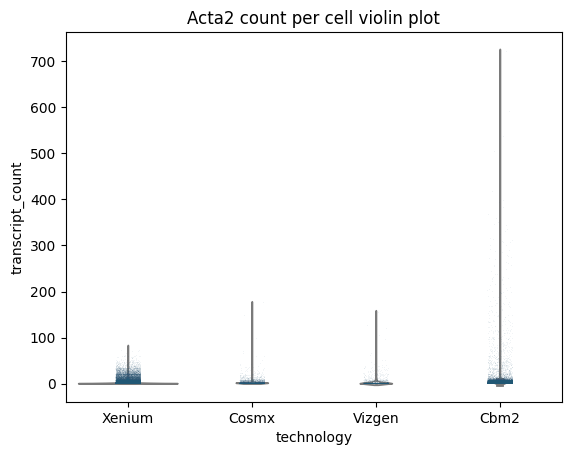

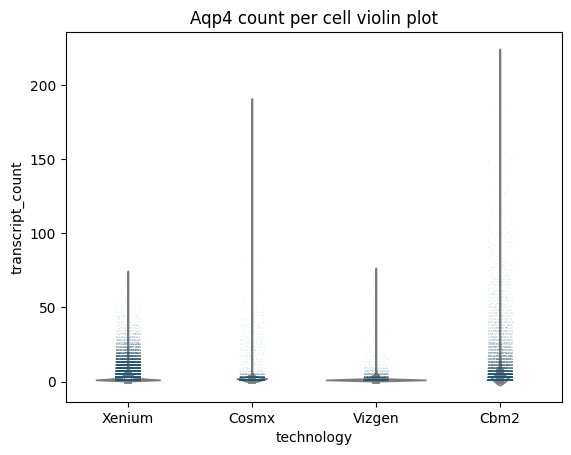

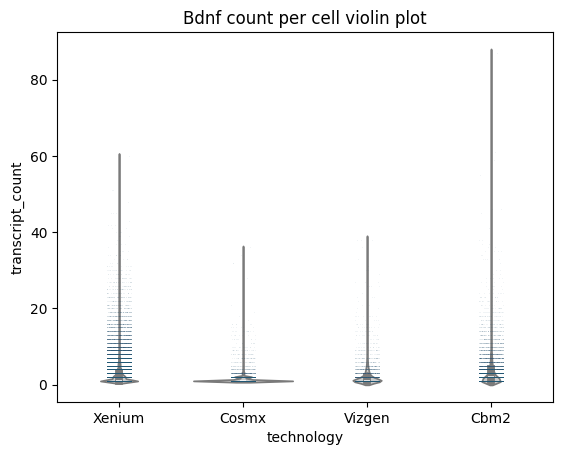

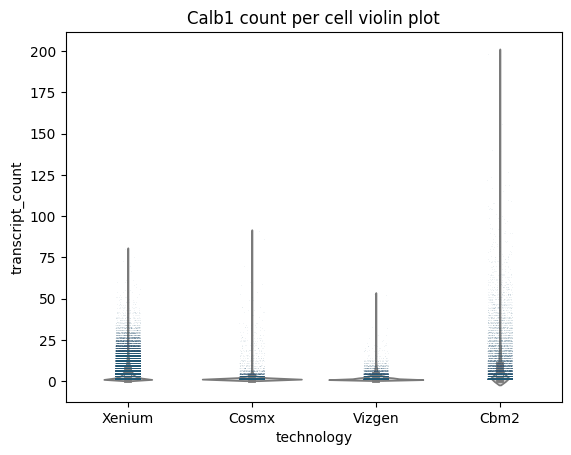

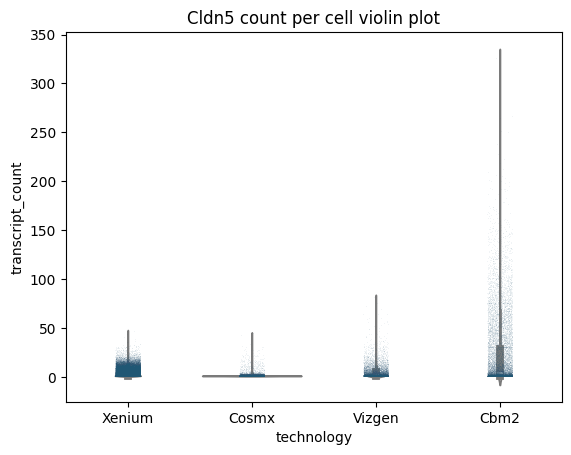

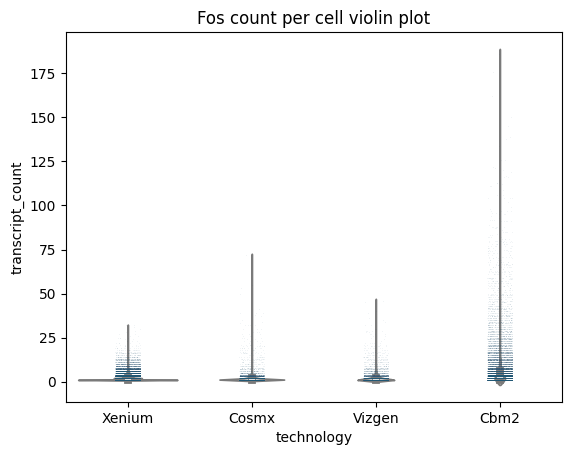

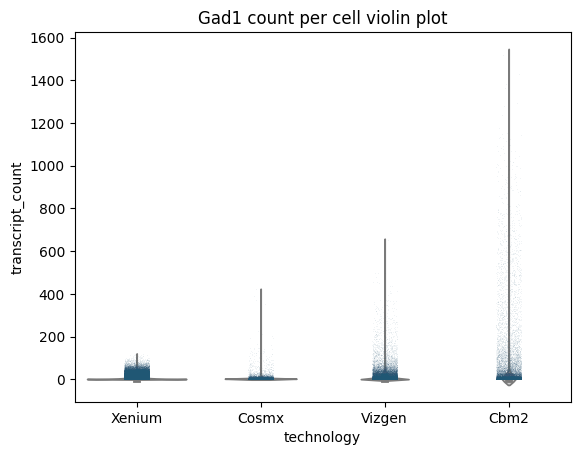

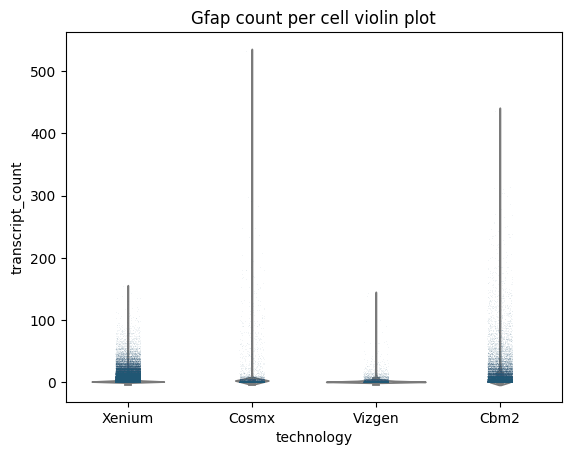

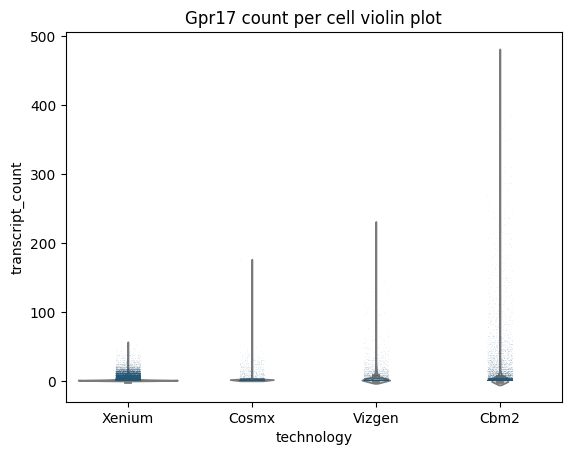

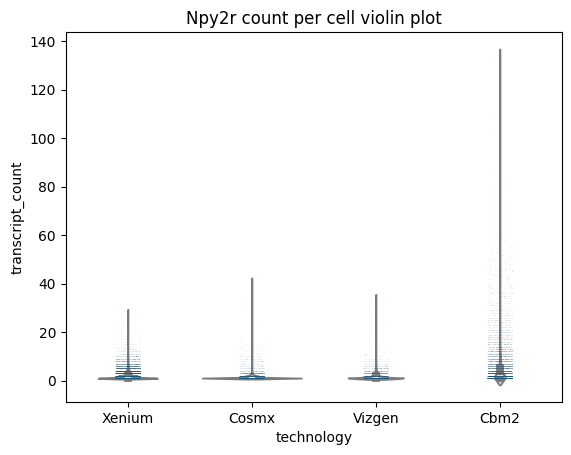

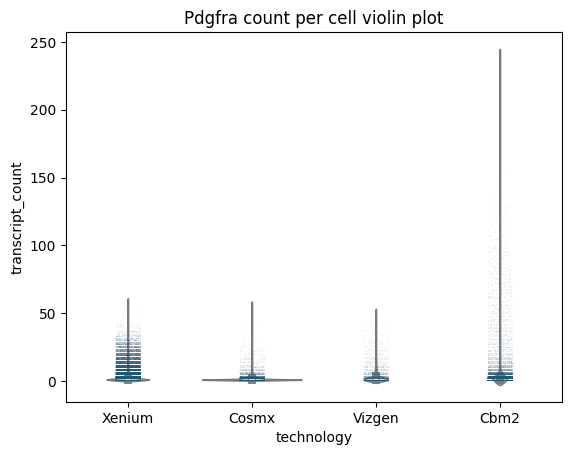

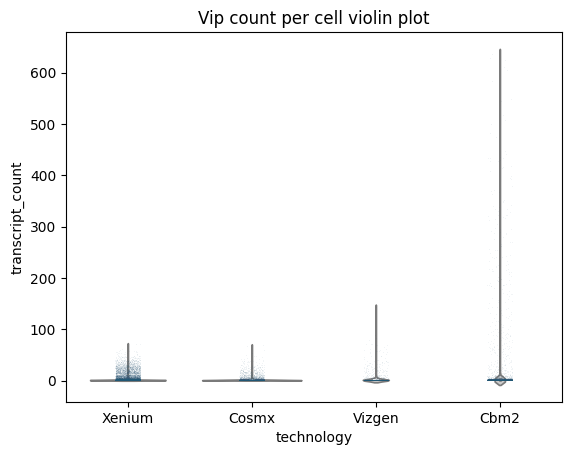

In [71]:
for gene in gene_overlap_list:
    xenium_overlap_filtered_gene = xenium_overlap_filtered[gene][xenium_overlap_filtered[gene] != 0]
    xenium_overlap_gene_df = pd.DataFrame()
    xenium_overlap_gene_df['transcript_count'] = xenium_overlap_filtered_gene
    xenium_overlap_gene_df['technology'] = 'Xenium'
    
    cosmx_overlap_filtered_gene = cosmx_overlap_filtered[gene][cosmx_overlap_filtered[gene] != 0]
    cosmx_overlap_gene_df = pd.DataFrame()
    cosmx_overlap_gene_df['transcript_count'] = cosmx_overlap_filtered_gene
    cosmx_overlap_gene_df['technology'] = 'Cosmx'
    
    vizgen_overlap_filtered_gene = vizgen_overlap_filtered[gene][vizgen_overlap_filtered[gene] != 0]
    vizgen_overlap_gene_df = pd.DataFrame()
    vizgen_overlap_gene_df['transcript_count'] = vizgen_overlap_filtered_gene
    vizgen_overlap_gene_df['technology'] = 'Vizgen'
    
    cbm2_overlap_filtered_gene = cbm2_overlap_filtered[gene][cbm2_overlap_filtered[gene] != 0]
    cbm2_overlap_gene_df = pd.DataFrame()
    cbm2_overlap_gene_df['transcript_count'] = cbm2_overlap_filtered_gene
    cbm2_overlap_gene_df['technology'] = 'Cbm2'
    
    concated_df = pd.DataFrame()
    concated_df = pd.concat([xenium_overlap_gene_df, cosmx_overlap_gene_df, vizgen_overlap_gene_df, cbm2_overlap_gene_df], ignore_index = True)

    sns.violinplot(x = 'technology', y = 'transcript_count', data = concated_df, color = '0.8')
    sns.stripplot(x = 'technology', y = 'transcript_count', data = concated_df, jitter = True, size = 0.15)
    plt.title(f'{gene} count per cell violin plot')
    plt.show()